In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import sklearn.metrics
import numpy as np

In [2]:
# Load files as df
data_1 = pd.read_csv('Milestone 1 Dataset/hr_temp_20170201-20200131_subset.csv')
data_2 = pd.read_csv('Milestone 1 Dataset/hrl_load_metered - 20170201-20200131.csv')

In [3]:
# Create data frame with only variables of interest
data = {'MW': data_2['mw'], 'Temp': data_1['HourlyDryBulbTemperature'], 'Date': data_1['DATE']}
data_df = pd.DataFrame(data)
data_df.head()

,MW,Temp,Date
0,1419.881,37.0,2017-02-01T00:53:00
1,1379.505,37.0,2017-02-01T01:53:00
2,1366.106,36.0,2017-02-01T02:53:00
3,1364.453,36.0,2017-02-01T03:53:00
4,1391.265,36.0,2017-02-01T04:53:00


In [4]:
# Cast as datetime
data_df['Date'] = pd.to_datetime(data_df['Date'])   

In [5]:
# Create time variables out of the 'Date' variable
data_df['hour'] = [x.hour for x in data_df['Date']]  #hour
data_df['dow'] =  [x.weekday() for x in data_df['Date']] #day of week
data_df['month'] =  [x.month for x in data_df['Date']] #month 
data_df['year'] = [x.year for x in data_df['Date']] #year

In [6]:
# Set 'Date' as index
data_df.set_index('Date', inplace=True)

In [7]:
# Fill in missing values in the 'Temp' variable by linear interpolation
data_df.interpolate(method='linear', inplace=True)
sum(data_df['Temp'].isnull())

0

In [8]:
# Divide data into training (until 12-31-2019) and testing (since January, 2020)
training = data_df[:'12-31-2019']
testing = data_df['01-01-2020':]

In [9]:
training.head()

,MW,Temp,hour,dow,month,year
Date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017


In [10]:
testing.head()

,MW,Temp,hour,dow,month,year
Date,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,2,1,2020


Text(0, 0.5, 'MW')

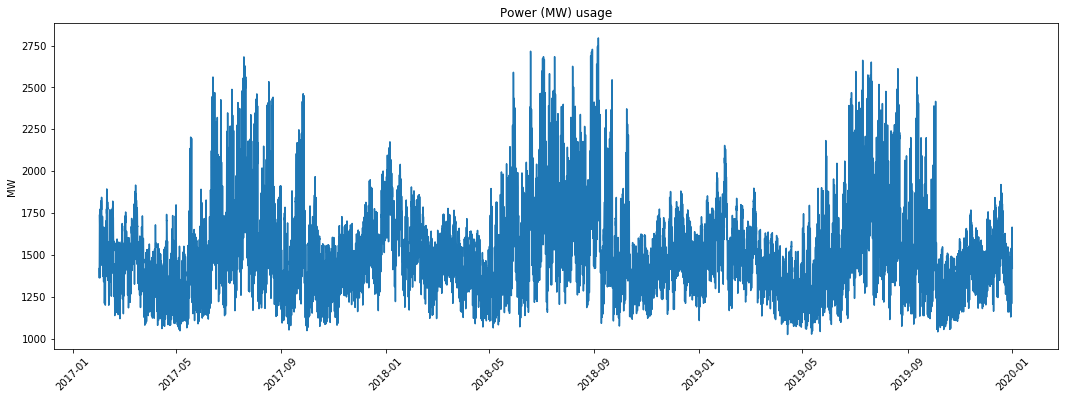

In [11]:
# Plot training energy data
plt.figure(figsize=(18,6))
plt.plot(training.index, training.MW)
plt.xticks(rotation = 45)
plt.title('Power (MW) usage')
plt.ylabel('MW')

- The highest amount of energy is consumed from May to September. 
- In January there is a second peek in energy consumption. 

Text(0, 0.5, 'MW')

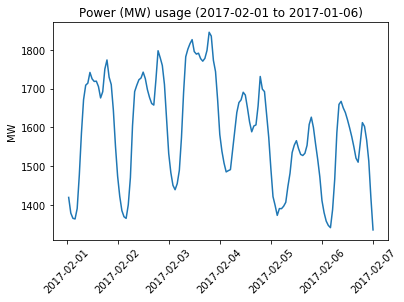

In [12]:
# Plot training energy data (one week only) 
plt.plot(training[:'2017-02-06'].index, training.MW[:'2017-02-06'])
plt.xticks(rotation = 45)
plt.title('Power (MW) usage (2017-02-01 to 2017-01-06)')
plt.ylabel('MW')

- Each day seem to show a single cycle with two peaks. 
- There is an upward tendency in the first three days.
- Then, it moves downwards the next two day (possibly weekends). 
- And the last day the tendency move back up again. 

Text(0, 0.5, 'Temperature')

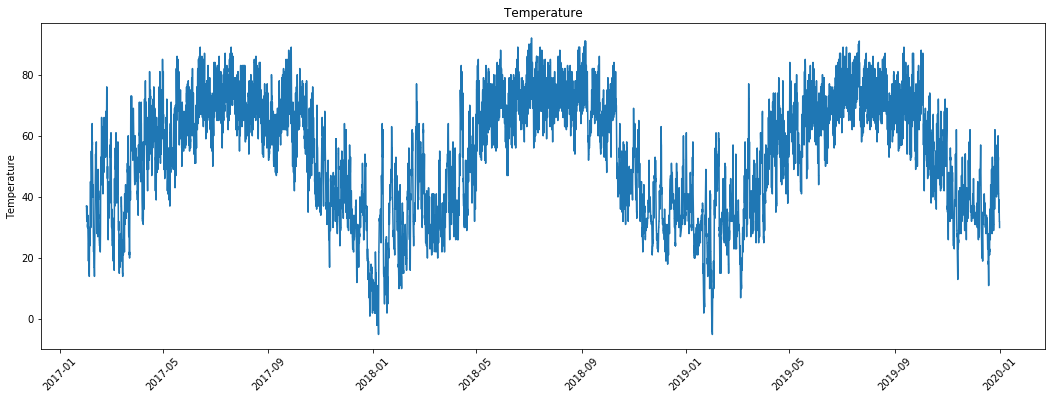

In [13]:
# Plot temperature data
plt.figure(figsize=(18,6))
plt.plot(training.index, training.Temp)
plt.xticks(rotation = 45)
plt.title('Temperature')
plt.ylabel('Temperature')

- Temperature is at its lowest point in January. 
- Then, temperature increases reaching its highest point in June - July.
- Then, temperature decreases until January. 

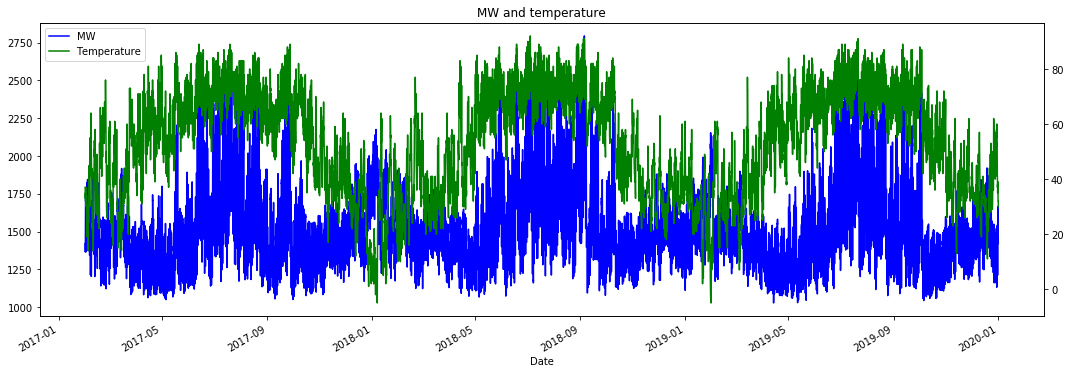

In [14]:
# Plot both power and temperature
plt.figure(figsize=(18,6))
ax1 = training['MW'].plot(color = 'blue', label='MW')
ax2 = ax1.twinx()
ax2 = training['Temp'].plot(color = 'green', label='Temperature')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.title('MW and temperature')
plt.show()

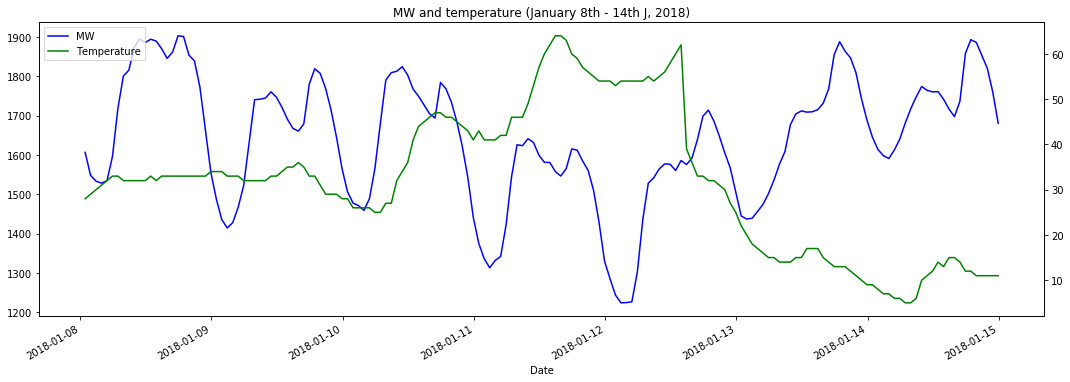

In [15]:
# Plot one week of energy and temperature data (January)
plt.figure(figsize=(18,6))
ax1 = training['2018-01-08':'2018-01-14']['MW'].plot(color = 'blue', label='MW')
ax2 = ax1.twinx()
ax2 = training['2018-01-08':'2018-01-14']['Temp'].plot(color = 'green', label='Temperature')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.title('MW and temperature (January 8th - 14th J, 2018)')
plt.show()

- Here in January, there is no clear pattern between temperature and energy. 

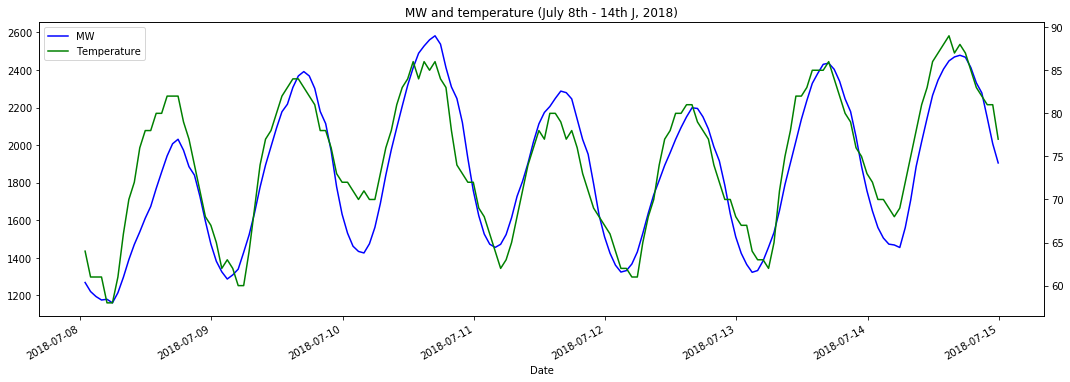

In [16]:
# Plot one week of energy and temperature data (July)
plt.figure(figsize=(18,6))
ax1 = training['2018-07-08':'2018-07-14']['MW'].plot(color = 'blue', label='MW')
ax2 = ax1.twinx()
ax2 = training['2018-07-08':'2018-07-14']['Temp'].plot(color = 'green', label='Temperature')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.title('MW and temperature (July 8th - 14th J, 2018)')
plt.show()

- Here in July, the energy used and the temperature seem to be highly correlated through the week period. 

In [17]:
# Calculate correlation between energy and temperature variables
corr_p, _ = pearsonr(training.MW, training.Temp)
corr_s, _ = spearmanr(training.MW, training.Temp)
print("Pearson's correlation: {}; Spearman's correlation: {}".format(corr_p, corr_s))

Pearson's correlation: 0.3275395569074121; Spearman's correlation: 0.31031864242384893


Text(0.5, 1.0, 'MW by Temperature')

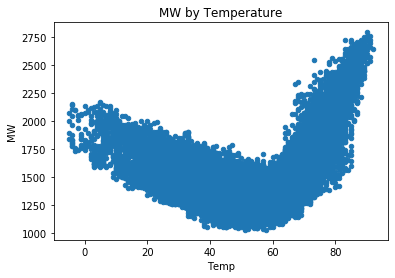

In [18]:
# Scatter plot of training energy and temperature data
data_df.plot.scatter('Temp', 'MW')
plt.title('MW by Temperature')

- Here, it seems that when the temperature ranges from approximately 30 to 70 degrees, the energy consumtion reaches an upper limit of 1500 MW. When the temperature moves up or down from this range, energy consumption increases. 
- Notice that energy consumption is higher with higher temperatures, though. 

In [19]:
# Create quadratic variable out of temperature
# First, standarize 'Temp' 
scaler = StandardScaler().fit(training['Temp'].values.reshape(-1, 1))
training['Temp_scaled'] = scaler.transform(training['Temp'].values.reshape(-1, 1))
training['Temp_2'] = training['Temp_scaled'] * training['Temp_scaled']
training.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,MW,Temp,hour,dow,month,year,Temp_scaled,Temp_2
Date,,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017,-0.871516,0.759540
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017,-0.871516,0.759540
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017,-0.924513,0.854723
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017,-0.924513,0.854723
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017,-0.924513,0.854723


In [20]:
# Fit a linear regression model 
model_1 = sm.OLS.from_formula('MW ~ Temp + Temp_2 + C(dow) + C(hour) + C(month)', data=training).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MW   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     3180.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:28:54   Log-Likelihood:            -1.5735e+05
No. Observations:               25536   AIC:                         3.148e+05
Df Residuals:                   25493   BIC:                         3.151e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        906.6991      5.782    156.818      0.000     895.366     918.032
C(dow)[T.1]        9.8039      2.691      3.644      0.000       4.530      15.077
C(dow)[T.2]       21.1134      2.693      7.841      0.000      15.836      26.391
C(dow)[T.3]       17.4519      2.693      6.481      0.000      12.174      22.730
C(dow)[T.4]        1.3846      2.693      0.514      0.607      -3.893       6.662
C(dow)[T.5]      -99.3658      2.693    -36.902      0.000    -104.644     -94.088
C(dow)[T.6]     -115.8115      2.690    -43.048      0.000    -121.085    -110.538
C(hour)[T.1]     -30.6108      4.981     -6.146      0.000     -40.373     -20.848
C(hour)[T.2]     -45.1860      4.981     -9.071      0.000     -54.950     -35.422
C(hour)[T.3]     -37.6119      4.982     -7.549      0.000     -47.377     -27.846
C(hour)[T.4]       3.7713      4.983      0.757      0.449      -5.996      13.539
C(hour)[T.5]      70.9284      4.984     14.232      0.000      61.160      80.697
C(hour)[T.6]     137.3154      4.982     27.562      0.000     127.550     147.081
C(hour)[T.7]     187.4329      4.981     37.628      0.000     177.669     197.196
C(hour)[T.8]     222.5454      4.985     44.644      0.000     212.775     232.316
C(hour)[T.9]     248.4646      4.995     49.739      0.000     238.673     258.256
C(hour)[T.10]    263.4295      5.011     52.571      0.000     253.608     273.251
C(hour)[T.11]    272.4943      5.027     54.207      0.000     262.641     282.347
C(hour)[T.12]    277.6490      5.042     55.065      0.000     267.766     287.532
C(hour)[T.13]    278.7407      5.052     55.175      0.000     268.839     288.643
C(hour)[T.14]    277.4274      5.056     54.868      0.000     267.517     287.338
C(hour)[T.15]    285.2792      5.051     56.477      0.000     275.378     295.180
C(hour)[T.16]    298.7924      5.039     59.300      0.000     288.916     308.668
C(hour)[T.17]    316.5233      5.023     63.021      0.000     306.679     326.368
C(hour)[T.18]    324.6099      5.006     64.839      0.000     314.797     334.423
C(hour)[T.19]    321.9333      4.994     64.458      0.000     312.144     331.723
C(hour)[T.20]    290.1282      4.988     58.163      0.000     280.351     299.905
C(hour)[T.21]    216.6446      4.984     43.466      0.000     206.875     226.414
C(hour)[T.22]    127.7315      4.982     25.639      0.000     117.967     137.496
C(hour)[T.23]     50.5350      4.981     10.146      0.000      40.772      60.298
C(month)[T.2]     17.8145      4.079      4.367      0.000       9.819      25.810
C(month)[T.3]    -11.2371      4.002     -2.808      0.005     -19.081      -3.393
C(month)[T.4]   -126.7104      4.399    -28.803      0.000    -135.333    -118.088
C(month)[T.5]   -125.2755      4.735    -26.455      0.000    -134.557    -115.994
C(month)[T.6

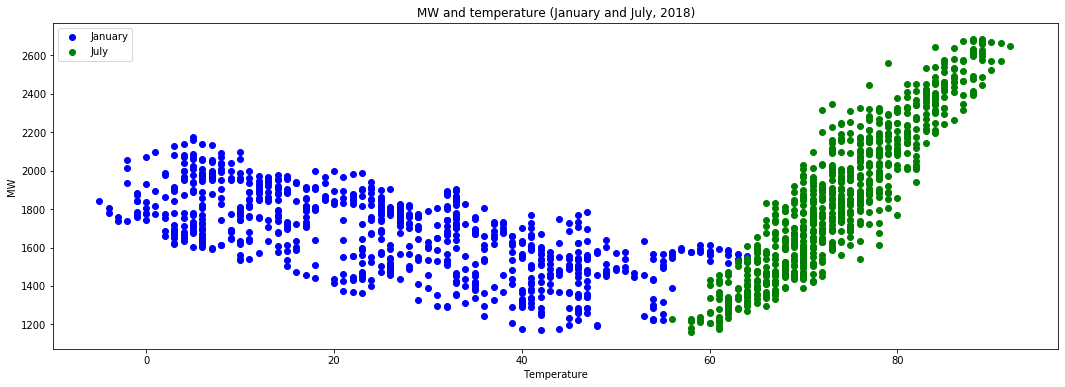

In [21]:
# Scatter plot of energy and temperature for the months of January and July
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(111)
ax1.scatter(training['2018-01']['Temp'], training['2018-01']['MW'], color='blue', label='January')
ax1.scatter(training['2018-07']['Temp'], training['2018-07']['MW'], color='green', label='July')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('MW')
plt.title('MW and temperature (January and July, 2018)')
plt.show()

- In January, there is a negative correlation between temperature and energy (MW) whereas in July there is a positive correlation between these two same variables. 

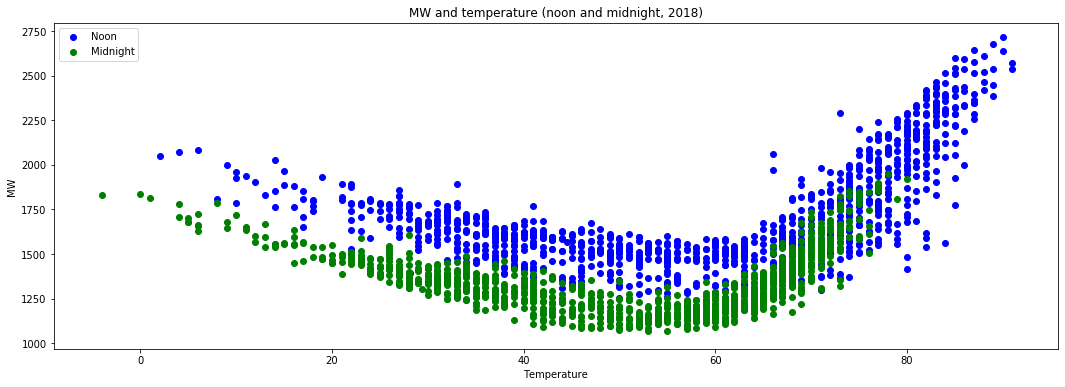

In [22]:
# Energy and temperature for the hours of midnight and noon and compare them for the same months as above
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(111)
ax1.scatter(training.between_time('12:00','13:00')['Temp'], training.between_time('12:00','13:00')['MW'], color='blue', label='Noon')
ax1.scatter(training.between_time('00:00','01:00')['Temp'], training.between_time('00:00','01:00')['MW'], color='green', label='Midnight')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('MW')
plt.title('MW and temperature (noon and midnight, 2018)')
plt.show()

- It seems that in both cases (noon and midnight), there is a quadratic relationship between the two variables. However, there is a higher energy usage at noon compared to midnight. 

In [23]:
# Build an OLS model including interaction terms for: hour of day * temperature, 
#                                                     hour of day * temperature squared, 
#                                                     month of year * temperature, 
#                                                     month of year * temperature squared

model_2 = sm.OLS.from_formula('MW ~ Temp + Temp_2 + C(dow) + C(hour) + C(month) + Temp*C(hour) + Temp_2*C(hour) + Temp*C(month) + Temp_2*C(month)', 
                              data=training).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MW   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2416.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:28:55   Log-Likelihood:            -1.4959e+05
No. Observations:               25536   AIC:                         2.994e+05
Df Residuals:                   25425   BIC:                         3.003e+05
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1473.7232     24.543     60.046      0.000    1425.617    1521.830
C(dow)[T.1]              10.0416      1.994      5.035      0.000       6.133      13.950
C(dow)[T.2]              24.6500      1.998     12.337      0.000      20.734      28.566
C(dow)[T.3]              28.4688      1.997     14.252      0.000      24.554      32.384
C(dow)[T.4]              10.5844      2.001      5.291      0.000       6.663      14.506
C(dow)[T.5]             -95.7491      1.997    -47.951      0.000     -99.663     -91.835
C(dow)[T.6]            -114.3568      1.992    -57.419      0.000    -118.260    -110.453
C(hour)[T.1]             -7.2228     17.384     -0.415      0.678     -41.296      26.851
C(hour)[T.2]            -28.2230     17.704     -1.594      0.111     -62.925       6.479
C(hour)[T.3]            -33.5762     17.919     -1.874      0.061     -68.699       1.547
C(hour)[T.4]            -25.6024     18.075     -1.416      0.157     -61.030       9.825
C(hour)[T.5]             56.2133     18.027      3.118      0.002      20.879      91.547
C(hour)[T.6]            197.6430     17.485     11.303      0.000     163.371     231.915
C(hour)[T.7]            299.8307     16.653     18.005      0.000     267.190     332.471
C(hour)[T.8]            365.3037     15.947     22.907      0.000     334.047     396.561
C(hour)[T.9]            414.4026     15.454     26.816      0.000     384.113     444.693
C(hour)[T.10]           436.5616     15.195     28.730      0.000     406.778     466.346
C(hour)[T.11]           430.6889     15.098     28.526      0.000     401.095     460.283
C(hour)[T.12]           419.4300     15.080     27.813      0.000     389.872     448.988
C(hour)[T.13]           397.4843     15.096     26.330      0.000     367.895     427.074
C(hour)[T.14]           354.5548     15.115     23.457      0.000     324.929     384.181
C(hour)[T.15]           311.7643     15.123     20.615      0.000     282.121     341.407
C(hour)[T.16]           300.7661     15.126     19.884      0.000     271.118     330.414
C(hour)[T.17]           350.1605     15.176     23.073      0.000     320.414     379.907
C(hour)[T.18]           349.5554     15.357     22.761      0.000     319.454     379.657
C(hour)[T.19]           290.2930     15.671     18.524      0.000     259.577     321.009
C(hour)[T.20]           221.1732     15.926     13.887      0.000     189.957     252.389
C(hour)[T.21]           163.2391     16.259     10.040      0.000     131.371     195.107
C(hour)[T.22]            96.2384     16.595      5.799      0.000      63.712     128.765
C(hour)[T.23]            35.3747     16.920      2.091      0.037       2.210      68.540
C(month)[T.2]           -65.8179     25.443     -2.587      0.010    -115.688     -15.948
C(month)[T.3]          

In [24]:
# Add interaction between hour of day and day of week to the model 
model_3 = sm.OLS.from_formula('MW ~ Temp + Temp_2 + C(dow) + C(hour) + C(month) + Temp*C(hour) + Temp_2*C(hour) + Temp*C(month) + Temp_2*C(month) + C(hour)*C(dow)', 
                              data=training).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MW   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1248.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:28:56   Log-Likelihood:            -1.4774e+05
No. Observations:               25536   AIC:                         2.960e+05
Df Residuals:                   25287   BIC:                         2.980e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1424.1216     23.561     60.445      0.000    1377.942    1470.302
C(dow)[T.1]                   6.1527      9.085      0.677      0.498     -11.654      23.960
C(dow)[T.2]                  32.7819      9.087      3.608      0.000      14.971      50.593
C(dow)[T.3]                  37.2304      9.092      4.095      0.000      19.409      55.052
C(dow)[T.4]                  37.0628      9.087      4.078      0.000      19.251      54.875
C(dow)[T.5]                  17.1413      9.087      1.886      0.059      -0.670      34.953
C(dow)[T.6]                  -9.1433      9.083     -1.007      0.314     -26.947       8.660
C(hour)[T.1]                 -6.2914     18.162     -0.346      0.729     -41.889      29.306
C(hour)[T.2]                -18.9004     18.425     -1.026      0.305     -55.014      17.213
C(hour)[T.3]                -17.3583     18.615     -0.932      0.351     -53.846      19.129
C(hour)[T.4]                  3.2356     18.759      0.172      0.863     -33.532      40.003
C(hour)[T.5]                108.2519     18.710      5.786      0.000      71.580     144.924
C(hour)[T.6]                263.3503     18.256     14.425      0.000     227.568     299.133
C(hour)[T.7]                365.6929     17.566     20.818      0.000     331.262     400.124
C(hour)[T.8]                427.2214     16.982     25.158      0.000     393.936     460.506
C(hour)[T.9]                474.5131     16.604     28.578      0.000     441.969     507.058
C(hour)[T.10]               497.3234     16.402     30.321      0.000     465.175     529.472
C(hour)[T.11]               492.5044     16.330     30.160      0.000     460.498     524.511
C(hour)[T.12]               488.6295     16.305     29.968      0.000     456.671     520.588
C(hour)[T.13]               458.2591     16.335     28.054      0.000     426.241     490.277
C(hour)[T.14]               415.9202     16.355     25.431      0.000     383.863     447.977
C(hour)[T.15]               367.8069     16.365     22.476      0.000     335.731     399.883
C(hour)[T.16]               354.3191     16.366     21.650      0.000     322.241     386.397
C(hour)[T.17]               405.8529     16.405     24.740      0.000     373.698     438.008
C(hour)[T.18]               406.3370     16.543     24.562      0.000     373.911     438.763
C(hour)[T.19]               341.5949     16.800     20.333      0.000     308.666     374.524
C(hour)[T.20]               263.7940     17.008     15.510      0.000     230.457     297.131
C(hour)[T.21]               195.6824     17.286     11.321      0.000     161.802     229.563
C(hour)[T.22]               114.7400     17.564      6.533      0.000      80.313     149.167
C(hour)[T.23]                43.0400     17.849      2.411      0.016      

In [25]:
# Calculate the MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = y_true, y_pred
    return np.round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

print('MAPE: {}'.format(mean_absolute_percentage_error(training['MW'], model_3.fittedvalues.values)))

MAPE: 3.51


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

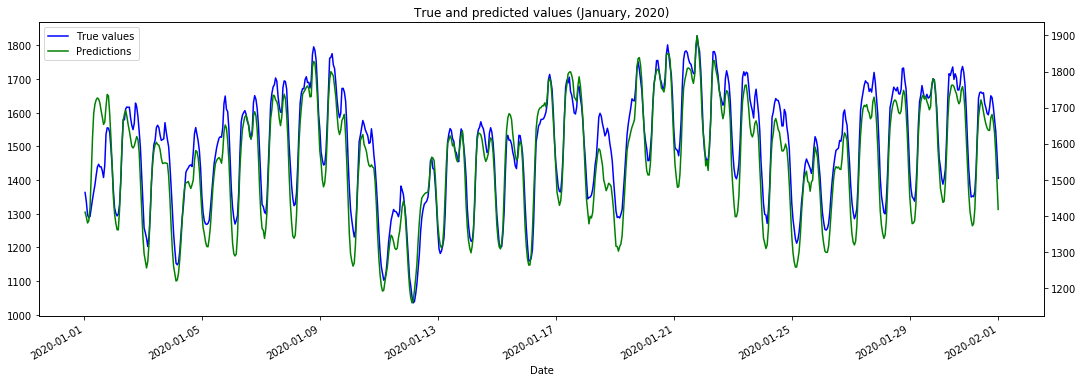

In [26]:
# Plot forecast against predicted values
testing['Temp_scaled'] = scaler.transform(testing['Temp'].values.reshape(-1, 1))
testing['Temp_2'] = testing['Temp_scaled'] * testing['Temp_scaled']

testing['predictions'] = model_3.predict(testing).values

plt.figure(figsize=(18,6))
ax1 = testing['MW'].plot(color = 'blue', label='True values')
ax2 = ax1.twinx()
ax2 = testing['predictions'].plot(color = 'green', label='Predictions')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.title('True and predicted values (January, 2020)')
plt.show()